异常值检测主要是为了发现数据集中的一些"与众不同"的数据值，所谓“与众不同”的数据是指这些数据与大多数数据存在较大的差异我们称之为“异常值”，并且在现实中这些“异常值”并没有被打上标签，因此我们必须通过某种算法来自动识别出这些异常值。对于异常值我们有如下的定义:

异常值所占整体数据的比例较少,产生异常值的概率非常低。   
异常值本身的特征与其他正常值有明显的差异。

# 数据

在本篇博客中我们的数据来自于国外某连锁零售企业的客流量与订单数量统计数据，为了让数据更加清晰，我们只保留了如下3个字段：

* date：日期,
* num_people: 客流量,
* num_order: 订单数量量

你可以在这里下载数据:

In [27]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();
sns.set_style("darkgrid",{"font.sans-serif":['simhei','Droid Sans Fallback']})
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
import warnings
warnings.filterwarnings("ignore")

In [19]:
df=pd.read_csv("order_num.csv")
df

,date,num_people,num_order
0,2019-01-01,1046.0,295.0
1,2019-01-02,733.0,191.0
2,2019-01-03,695.0,222.0
3,2019-01-04,580.0,193.0
4,2019-01-05,844.0,285.0
...,...,...,...
890,2020-10-31,NaN,346.0
891,2020-11-30,NaN,204.0
892,2020-12-31,NaN,288.0
893,2021-01-31,NaN,254.0


# 过滤缺失值

除异常值以外,真实的数据中往往还会存在数据缺失的情况(即有些数据的值为NaN),对于缺失值一般会有2种处理方式比如:1.直接删除缺失值;2.对缺失值进行填充.对缺失值进行填充时一般会用均值或者使用某些插值算法插入一些符合数据历史趋势的数值。在这里我们使用最简单的方式即直接删除缺失值的方式来处理数据缺失，这样做的目的是让问题简单化。

In [20]:
print("在 num_people 列中总共有 %d 个空值." % df['num_people'].isnull().sum())
print("在 num_order 列中总共有 %d 个空值." % df['num_order'].isnull().sum())
df=df[~df.num_people.isnull()==True]
df=df[~df.num_order.isnull()==True]
print("删除缺失值以后记录总数:",len(df))

在 num_people 列中总共有 58 个空值.
在 num_order 列中总共有 35 个空值.
删除缺失值以后记录总数: 802


# 查看客流量、客流量数据分布

count      802.000000
mean      1002.246883
std        698.302067
min          9.000000
25%        694.250000
50%        921.500000
75%       1190.500000
max      15087.000000
Name: num_people, dtype: float64

count    802.000000
mean     248.438903
std       73.424284
min        3.000000
25%      193.000000
50%      241.000000
75%      296.750000
max      588.000000
Name: num_order, dtype: float64


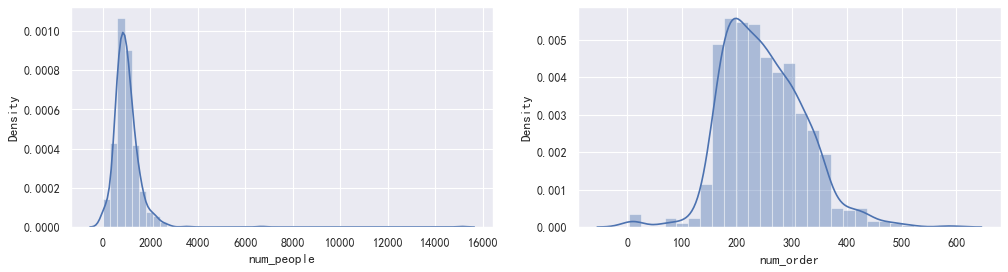

In [21]:
print(df.num_people.describe())
print()
print(df.num_order.describe())
plt.figure(figsize=(15,8), dpi=80)
plt.subplot(221)
sns.distplot(df['num_people']);

plt.subplot(222)
sns.distplot(df['num_order']);

In [22]:


# plt.subplot(223)
# sns.boxenplot(y=df["num_people"])

# plt.subplot(224)
# sns.boxenplot(y=df["num_people"])

从分布上看客流量(num_people)明显严重右偏,右侧有长尾,并且我们看到客流量(num_people)的异常区域大致应该分布在上图的红圈范围内。而订单量数据呈现正太分布,异常值区域位于分布左右两侧。下面我们查看num_people的偏度(Skewness)与峰度(Kurtosis)，偏度反应的是分布的偏斜程度,可能是左偏，右偏，长尾等形态，峰度反应分布的形状的胖瘦(宽窄),具体解释请参考这篇博客: https://blog.csdn.net/binbigdata/article/details/79897160

In [23]:
print("num_people's Skewness: %f" % df['num_people'].skew())
print("num_people's Kurtosis: %f " % df['num_people'].kurt())
print()
print("num_order's Skewness: %f" % df['num_order'].skew())
print("num_order's Kurtosis: %f" % df['num_order'].kurt())

num_people's Skewness: 11.165755
num_people's Kurtosis: 211.579274 

num_order's Skewness: 0.429138
num_order's Kurtosis: 1.114412


# IsolationForest(隔离森林)

IsolationForest是一种简单有效的检测异常值的算法，它可以在数据的分布区域中找出异常值所在的区域，并对所有数据进行评分，那些落在异常区域的数据值会获得较低的分数，而那些不在异常区域中的数据将会获得较高的分数,大家可以参考这篇文章(https://dzone.com/articles/spotting-outliers-with-isolation-forest-using-skle )。在这篇文章中作者随机生成了两个正太分布N(-2,5)和N(2,5),同时通过隔离森林算法找到到了这两个分布中的异常区域,并且生成一条评分曲线,落在异常区域内的数据将会得到低分，落在异常区域内以外的数据将会获得高分:

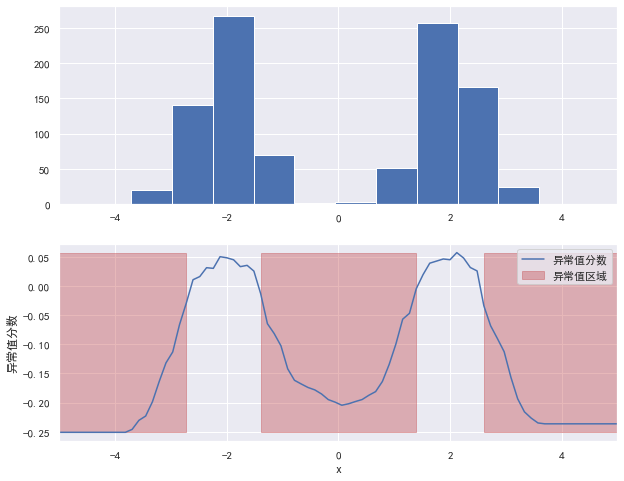

In [24]:
import numpy as np 
import matplotlib.pyplot as plt 
x = np.concatenate((np.random.normal(loc=-2, scale=.5,size=500), np.random.normal(loc=2, scale=.5, size=500)))

isolation_forest = IsolationForest(n_estimators=100) 
isolation_forest.fit(x.reshape(-1, 1)) 
xx = np.linspace(-6, 6, 100).reshape(-1,1) 
anomaly_score = isolation_forest.decision_function(xx) 
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.hist(x) 
plt.xlim([-5, 5]) 

plt.subplot(2,1,2)
plt.plot(xx, anomaly_score, label='异常值分数') 
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where=outlier==-1, color='r', alpha=.4, label='异常值区域') 
plt.legend() 
plt.ylabel('异常值分数') 
plt.xlabel('x') 
plt.xlim([-5, 5]) 
plt.show()

# 使用隔离森林算法来监测客流量,订单量的异常值区域

隔离森林是一种检测异常值的算法，使用IsolationForest算法返回每个样本的异常分数，该算法基于这样的思想:异常是少数和在特征上不同的数据点。隔离森林是一种基于树的模型。在这些树中，通过首先随机选择特征然后在所选特征的最小值和最大值之间选择随机分割值来创建分区。下面我们使用隔离森林算法来探测客流量与订单量的异常值区域,并生成评分曲线:

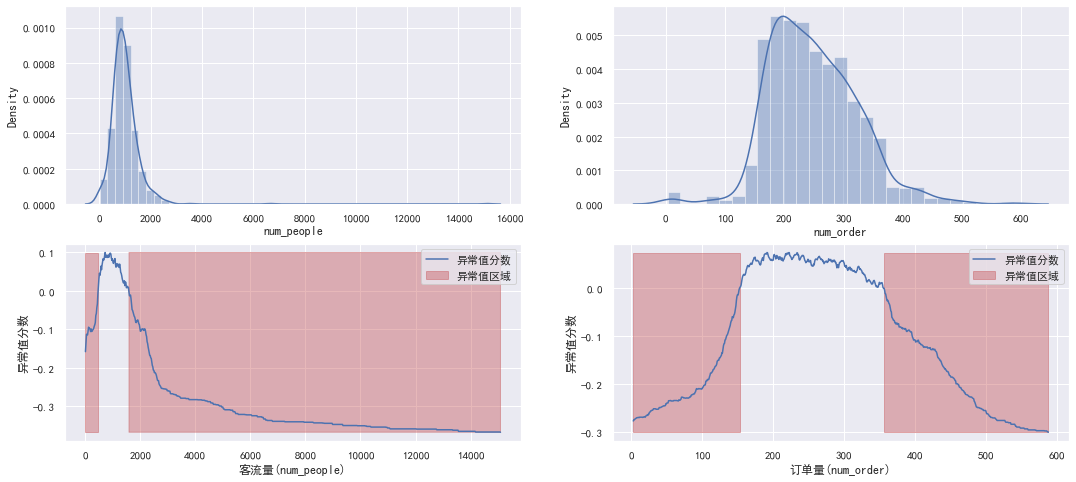

In [26]:
#定义隔离森林
IF1 = IsolationForest(n_estimators=100)
#训练客流量数据
IF1.fit(df['num_people'].values.reshape(-1, 1))
#在客流量的最小值和最大值之间分割数据
x1 = np.linspace(df['num_people'].min(), df['num_people'].max(), len(df)).reshape(-1,1)
#生成所有数据的异常值分数
anomaly_score1 = IF1.decision_function(x1)
#预测异常值
outlier1 = IF1.predict(x1)

IF2 = IsolationForest(n_estimators=100)
#训练订单量数据
IF2.fit(df['num_order'].values.reshape(-1, 1))
#在订单量的最小值和最大值之间分割数据
x2 = np.linspace(df['num_order'].min(), df['num_order'].max(), len(df)).reshape(-1,1)
#生成所有数据的异常值分数
anomaly_score2 = IF2.decision_function(x2)
#预测异常值
outlier2 = IF2.predict(x2)

plt.figure(figsize=(18,8))
plt.subplot(2,2,1)
sns.distplot(df['num_people'])

plt.subplot(2,2,2)
sns.distplot(df['num_order'])

plt.subplot(2,2,3)
plt.plot(x1, anomaly_score1, label='异常值分数')
plt.fill_between(x1.T[0], np.min(anomaly_score1), np.max(anomaly_score1), 
                 where=outlier1==-1, color='r', 
                 alpha=.4, label='异常值区域')
plt.legend()
plt.ylabel('异常值分数')
plt.xlabel('客流量(num_people)')

plt.subplot(2,2,4)
plt.plot(x2, anomaly_score2, label='异常值分数')
plt.fill_between(x2.T[0], np.min(anomaly_score2), np.max(anomaly_score2), 
                 where=outlier2==-1, color='r', 
                 alpha=.4, label='异常值区域')
plt.legend()
plt.ylabel('异常值分数')
plt.xlabel('订单量(num_order)')
plt.show();

在上图中隔离森林算法轻松的探测出来了客流量(num_people)与订单量(num_order)的异常值区域，并生成了评分曲线。当数据落在红色矩形区域内时将会得到较低的分数,而当数据落在红色矩形框的范围之外将会得到较高的分数。下面我们计算每个分布的异常值区域的边界值(上图红圈中的值)：

In [9]:
x1_outlier = x1[outlier1==-1]
right_min=x1_outlier[x1_outlier>1000].min()
left_max = x1_outlier[x1_outlier<1000].max()
print('客流量异常值区域中左侧最大异常值为：',df[df.num_people<=left_max].num_people.max())
print('客流量异常值区域中右侧最小异常值为：',df[df.num_people>=right_min].num_people.min())
print()
x2_outlier = x2[outlier2==-1]
right_min=x2_outlier[x2_outlier>248].min()
left_max = x2_outlier[x2_outlier<248].max()
print('订单量异常值区域中左侧最大异常值为：',df[df.num_order<=left_max].num_order.max())
print('订单量异常值区域中右侧最小异常值为：',df[df.num_order>=right_min].num_order.min())


客流量异常值区域中左侧最大异常值为： 459.0
客流量异常值区域中右侧最小异常值为： 1520.0

订单量异常值区域中左侧最大异常值为： 153.0
订单量异常值区域中右侧最小异常值为： 348.0


我们分别计算了客流量和订单量的异常值区域(红色区域)的边界值:  
客流量异常值所在区域:x<=459 和 x>=1508  
订单量异常值所在区域:x<=156 和 x>=357  



上述两个可视化结果显示了异常值分数并突出显示异常值所在的区域。从图中可见异常分数反映了基础分布的形状，异常区域对应于低概率区域。然而，到目前为止我们只是对客流量和订单量这两个单一变量分别进行了分析。如果我们仔细研究,可能会发现，由我们的模型确定的一些异常值只不过是数学统计上的异常,它可能并非是我们业务场景中的异常值,比如某些时候订单量很高可能是由于客流量很高所导致,它可能在统计分布上是异常值,但它在实际的业务场景中并不应该是异常值。下面我们同时观察客流量(num_people)和订单量(num_order)这两个变量的散点分布,并对客流量和订单量进行线性拟合,那些严重偏离拟合曲线的点,可以被认为是异常值,以这样的方式来判定异常值更符合实际的业务场景。

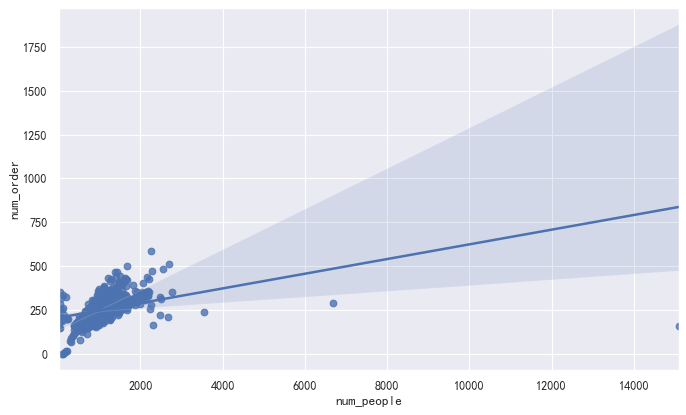

In [10]:
plt.figure(figsize=(10,6), dpi=80)
sns.regplot(data=df,x="num_people", y="num_order");

当我们的数据不是单变量而是多维度变量时，异常检测的方法使得计算难道更高并且在数学上更复杂。

# 关于PyOD


PyOD 是一个全面且可扩展的Python 工具包，用于检测多维数据中的异常对象。这个令人兴奋但具有挑战性的领域通常被称为 异常值检测 或异常检测。

PyOD 包括 30 多种检测算法，从经典的 LOF (SIGMOD 2000) 到最新的 COPOD (ICDM 2020)。自 2017 年以来，PyOD [ AZNL19 ]已成功应用于众多学术研究和商业产品[ AGSW19 , ALCJ+19 , AWDL+19 , AZNHL19 ]。它也得到了机器学习社区的广泛认可，有各种专门的帖子/教程，包括 Analytics Vidhya、 Towards Data Science、 KDnuggets、 Computer Vision News和 awesome-machine-learning。

PyOD官方文档:https://pyod.readthedocs.io/en/latest/index.html




## 本例中将会使用以下种类的异常探测模型：  

###  1.异常探测的线性模型

PCA：主成分分析使用到特征向量超平面的加权投影距离之和作为异常值异常值）  
MCD：最小协方差行列式（使用马氏距离作为异常值）  
OCSVM：一类支持向量机  

### 2.基于邻近度的异常值检测模型

LOF：局部异常因子  
CBLOF：基于聚类的局部异常值因子  
kNN：k Nearest Neighbors（使用到第k个最近邻居的距离作为异常值）  
Median kNN 异常值检测（使用到 k 个最近邻居的中值距离作为异常值分数）   
HBOS：基于直方图的异常值分数  

### 3.异常值检测的概率模型

ABOD：基于角度的异常值检测

### 4.使用集成分类(回归)器的异常检查模型

Isolation Forest：隔离森林  
Feature Bagging：特征装袋  
LSCP

## 使用PyOD 进行异常检测步骤

* 数据缩放：将客流量和订单量标准化处理将其缩放到0到1之间。  
* 设置异常值比例: 根据经验将设置异常值比例设置为1％。
* 初始化异常检查模型: 初始化12种异常检测模型。
* 拟合数据：使用异常检测模型拟合数据并预测结果。  
* 判断异常值：使用阈值来判断数据点是正常值还是异常值。  
* 计算异常值分数：使用决策函数计算每个点的异常值分数。  


下面的代码参考了"比较所有已实现的离群值检测模型的例子"(https://github.com/yzhao062/pyod/blob/master/notebooks/Compare%20All%20Models.ipynb) 和"使用PyOD库在Python中学习异常检测的一个很棒的教程"(https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/) 这两篇文章。

# 对数据进行缩放

将客流量和订单量标准化处理将其缩放到0到1之间

In [11]:
#数据缩放
cols = ['num_people', 'num_order']
minmax = MinMaxScaler(feature_range=(0, 1))
print(df[cols].head())
print('--------------------------')
df[['num_people','num_order']] = minmax.fit_transform(df[cols])
print(df[cols].head())

   num_people  num_order
0      1046.0      295.0
1       733.0      191.0
2       695.0      222.0
3       580.0      193.0
4       844.0      285.0
--------------------------
   num_people  num_order
0    0.068776   0.499145
1    0.048017   0.321368
2    0.045497   0.374359
3    0.037870   0.324786
4    0.055379   0.482051


# 初始化异常值检测模型

在这里我们将初始化常见的12种异常检测模型

In [12]:
#设定异常值比例
outliers_fraction = 0.01

# 初始化 LSCP 探测集
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=0),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=0),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=0),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=0),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=0),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=0)
}

for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Feature Bagging
Model 4 Histogram-base Outlier Detection (HBOS)
Model 5 Isolation Forest
Model 6 K Nearest Neighbors (KNN)
Model 7 Average KNN
Model 8 Local Outlier Factor (LOF)
Model 9 Minimum Covariance Determinant (MCD)
Model 10 One-class SVM (OCSVM)
Model 11 Principal Component Analysis (PCA)
Model 12 Locally Selective Combination (LSCP)


# 计算异常值

在这里我们要做的是拟合数据,预测异常和正常数据,计算异常值分数,最后进行可视化。

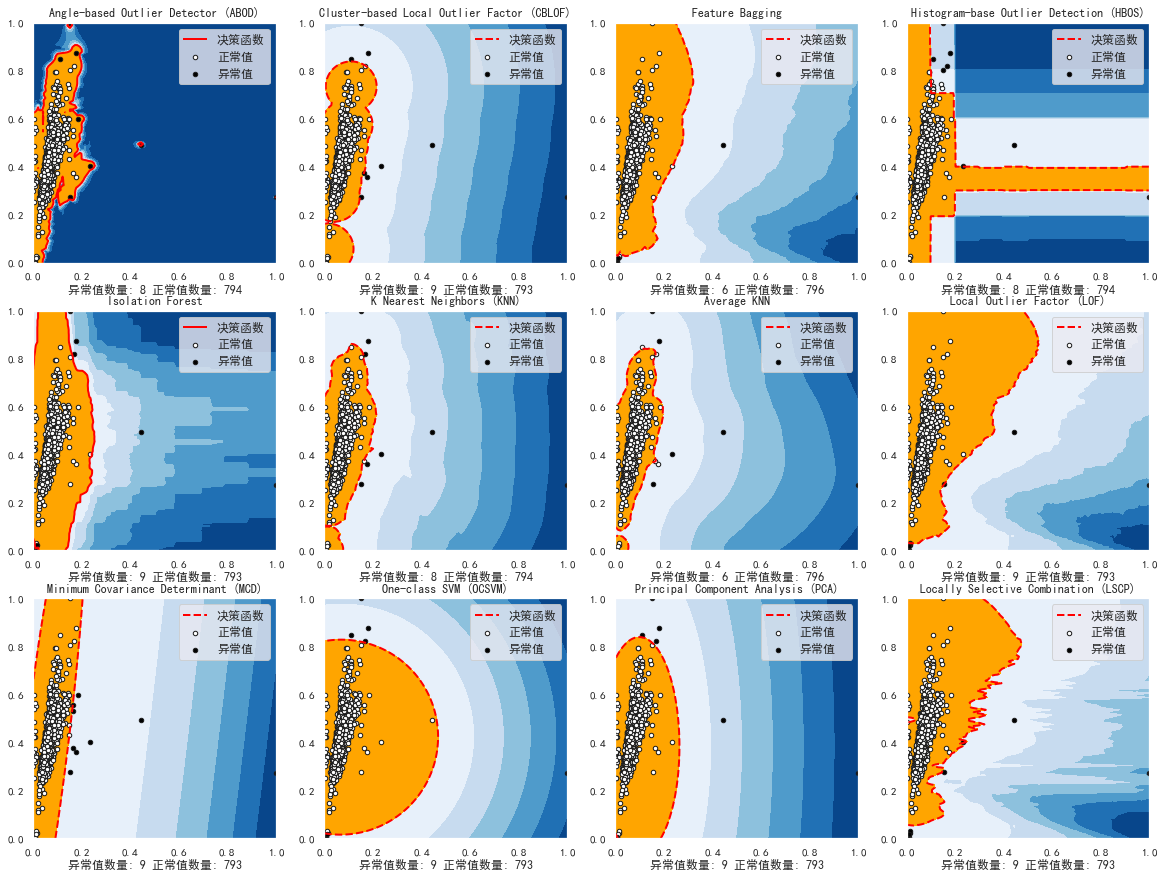

In [13]:
#将num_people和num_order合并成一个两列的numpy数组
X1= df['num_people'].values.reshape(-1,1)
X2 = df['num_order'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)

xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.figure(figsize=(20, 15))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    #训练数据
    clf.fit(X)
    # 预测异常值分数
    scores_pred = clf.decision_function(X) * -1
    # 预测异常值和正常值的数据
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)

    df1 = df
    df1['outlier'] = y_pred.tolist()
    #过滤出num_people和num_order的正常值
    inliers_people = np.array(df1['num_people'][df1['outlier'] == 0]).reshape(-1,1)
    inliers_order = np.array(df1['num_order'][df1['outlier'] == 0]).reshape(-1,1)

    #过滤出num_people和num_order的异常值
    outliers_people = df1['num_people'][df1['outlier'] == 1].values.reshape(-1,1)
    outliers_order = df1['num_order'][df1['outlier'] == 1].values.reshape(-1,1)
        
    # 设定一个阈值用以识别正常值和异常值的标准
    threshold = np.percentile(scores_pred, 100 * outliers_fraction)

    #决策函数为每一个数据点计算异常值分数
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    
    plt.subplot(3,4,i+1)
    #在图上对从最小的异常值分数到阈值的范围内进行分层着色
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    #在异常值分数等于阈值处画红色线条
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    
    #填充橙色轮廓线，其中异常分数的范围是从阈值到最大异常分数
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
    b = plt.scatter(x=inliers_people, y=inliers_order, c='white',s=20, edgecolor='k')    
    c = plt.scatter(x=outliers_people, y=outliers_order, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')   
    plt.legend([a.collections[0], b,c], ['决策函数', '正常值','异常值'],
                prop=matplotlib.font_manager.FontProperties(size=12),loc='upper right')

    plt.xlim((0, 1))
    plt.ylim((0, 1))
    ss = '异常值数量: '+str(n_outliers)+' 正常值数量: '+str(n_inliers)
    plt.title(clf_name)
    plt.xlabel(ss)
plt.show();
    
    

# 参考资料

### CBLOF(Cluster-based Local Outlier Factor)

CBLOF算法时基于聚类组的本地异常因子计算异常值分数。
CBLOF将数据集和由聚类算法生成的聚类模型作为输入。它使用参数alpha和beta将群集分为小群集和大群集。然后基于该点所属的聚类的大小以及到最近的大聚类的距离来计算异常分数。我们使用PyOD(https://pyod.readthedocs.io/en/latest/index.html) 库来实现CBLOF算法(https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cblof)

### 基于直方图的离群值检测（HBOS）¶

HBOS(https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.hbos) 假设特征独立，并通过构建直方图来计算异常程度。 在多变量异常检测中，可以计算每个单个特征的直方图，单独评分并在最后组合。 使用PyOD库时，代码与CBLOF非常相似。


### 隔离森林

隔离森林其原理与随机森林类似，建立在决策树的基础上。 隔离林通过随机选择特征然后根据特征的最大值和最小值之间的分割值来隔离观察。 PyOD Isolation Forest模块(https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest) 是Scikit-learn Isolation Forest的wrapper，它具有更多功能。其代码与之前的CBLOF非常相似。


### KNN(K - Nearest Neighbors)

用于离群检测的pyod.models.knn.KNN(https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn)。 对于数据，它与第k个最近邻居的距离可以被视为异常值。其代码与之前的CBLOF非常相似。


Example of Comparing All Implemented Outlier Detection Models :https://github.com/yzhao062/pyod/blob/master/notebooks/Compare%20All%20Models.ipynb


An Awesome Tutorial to Learn Outlier Detection in Python using PyOD Library:
https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/